### This notebook allows you to reproduce Figures 1 and 3,  and Table 3 for the full portfolio of scientists in chemistry.

In [1]:
from metrics import *
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':22})
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import StandardScaler

### Number of authors in the dataset - Table 1

There are two datasets, one for **baseline scientists** and one for **Nobelists**.

Each dataset is a pickle file containing a dictionary with keys **citations** and **c10s**. The values for both keys are list of lists. The ordering of the two lists (citations and c10s) is the same, i.e., *citations[i]* and *c10s[i]* are for the same scientist *i*.

- *citations[i]*: List of citations received by scientist *i* for each of their publications.
- *c10s[i]*: List of c10 values for each of the publications of scientist *i*.

Note that *len(c10s[i]) $\leq$ len(citations[i])*, since some publications might be less than 10 years old, in which case c10 is not defined.

In [2]:
data_baseline=pkl.load(open('data/baseline_chemistry.pickle','rb'))
data_nobelists=pkl.load(open('data/nobelists_chemistry.pickle','rb'))

In [3]:
print('Number of baseline scientists in chemistry: {}'.format(len(data_baseline['citations'])))
print('Number of Nobelists in chemistry: {}'.format(len(data_nobelists['citations'])))

Number of baseline scientists in chemistry: 3330
Number of Nobelists in chemistry: 51


### Calculate measures for each author

In [4]:
measures = ['N','C_tot','C_avg','C_max','H','G','Q_tilde','Q','M_alpha','E']
symbols = ['$N$','$C_\text{tot}$','$C_\text{avg}$','$C_\text{max}$','$H$','$G$','$\tilde Q$','$Q$','$M_\\alpha$','$E$']

In [5]:
def author_measures(data):
    df=pd.DataFrame(columns=measures)
    for i in range(len(data['citations'])):
        cs = data['citations'][i]
        c10s = data['c10s'][i]
        N = cs.shape[0]
        C_tot = sum(cs)
        C_avg = C_tot/N
        C_max = max(cs)
        H = h_index(cs)
        G = g_index(cs)
        Q_tilde = q_index(cs)
        Q = q_index(c10s)
        M_alpha = citation_moment(cs, alpha=0.2)
        E = E_index(cs)
        
        df.loc[len(df)] = [N, C_tot, C_avg, C_max, H, G, Q_tilde, Q, M_alpha, E]
    
    return(df)

In [6]:
df_baseline = author_measures(data_baseline)
df_nobelists = author_measures(data_nobelists)

### Scatter plot - number of papers ($N$) vs total citations ($C_{tot}$) - Figure 1

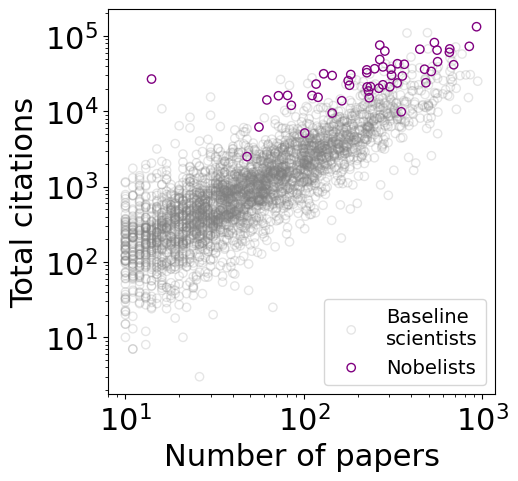

In [7]:
plt.figure(figsize=(5,5))
plt.scatter(df_baseline.N,df_baseline.C_tot,color='grey',facecolors='none',alpha=0.2,label='Baseline\nscientists')
plt.scatter(df_nobelists.N,df_nobelists.C_tot,color='purple',facecolors='none',label='Nobelists')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of papers')
plt.ylabel('Total citations')
plt.legend(fontsize=14)
plt.show()

### Optimal alpha selection - Figure 3

In [8]:
alphas=[np.round(a,2) for a in np.arange(0.01,0.1,0.01)]+[np.round(a,2) for a in list(np.arange(0.1,2.6,0.1))]

In [9]:
auc_pr=[]
y=[0]*len(data_baseline['citations'])+[1]*len(data_nobelists['citations'])
for alpha in alphas:
    M_alpha_baseline = [citation_moment(a,alpha=alpha) for a in data_baseline['citations']]
    M_alpha_nobelists = [citation_moment(a,alpha=alpha) for a in data_nobelists['citations']]
    X = np.array(M_alpha_baseline+M_alpha_nobelists).reshape(-1, 1)
    X = StandardScaler().fit_transform(X)
    auc_pr.append(average_precision_score(y,X))

In [10]:
optimal_alpha = alphas[np.where(np.array(auc_pr)==max(auc_pr))[0][0]]
print('Optimal alpha for chemistry: {}'.format(optimal_alpha))

Optimal alpha for chemistry: 0.2


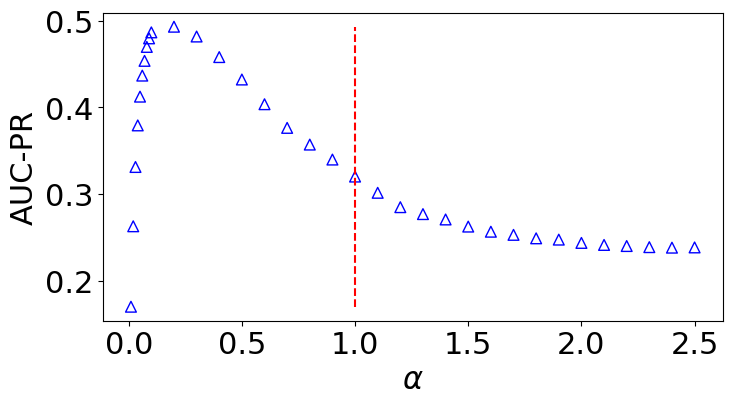

In [11]:
plt.figure(figsize=(8,4))
plt.vlines(x=1,ymin=min(auc_pr),ymax=max(auc_pr),color='red',linestyles='--')
plt.scatter(alphas,auc_pr,marker='^',s=60,edgecolors='blue',facecolors='none')
plt.xlabel('$\\alpha$')
plt.ylabel('AUC-PR')
plt.show()

### Classification of full portfolios - Table 3

In [12]:
y=[0]*len(data_baseline['citations'])+[1]*len(data_nobelists['citations'])
X=pd.concat([df_baseline, df_nobelists])
X[X.columns]=StandardScaler().fit(X).fit_transform(X[X.columns])
auc_pr=[average_precision_score(y,X[[c]]) for c in X.columns]

In [13]:
pd.DataFrame({'AUC-PR':[np.round(a,2) for a in auc_pr]},index=symbols)

,AUC-PR
$N$,0.13
$C_\text{tot}$,0.43
$C_\text{avg}$,0.32
$C_\text{max}$,0.25
$H$,0.44
$G$,0.41
$\tilde Q$,0.32
$Q$,0.13
$M_\alpha$,0.49
$E$,0.53
